# Nanocourse - Genomic analysis using sketching techniques




## Sketching

A *data sketch* of data $X$ is the output of a (randomized) function $f$ s.t.:
 - $|f(X)| \subseteq o(|X|)$
 - $f$ perserves some properties of $X$ e.g. approximation of the number of distinct elements
 - $f$ preserves certain similarity measures e.g. number of shared elements
 - $f(X)$ allows to be updated efficiently


## Counting distinct elements of a set

In an **online** setting (stream)


### Naive solution

Using a Hashmap or a Bitvector

**TODO:** Implement naive_counting() in naive_couting.cpp

Test it by running
```
./build/source/naivecounting data/ecoli1_k31_ust.fa.gz
```
The output should be
```
Distinct kmers: 4877400
```
How much memory consumption do you expect?

Let us check that in practice:

In [1]:
import os
from evaluate.track import track_memory_and_runtime
import numpy as np

files = ["data/ecoli1_k31_ust.fa.gz", "data/ecoli2_k31_ust.fa.gz", "data/ecoli4_k31_ust.fa.gz",
         "data/yeast.k31.unitigs.fa.ust.fa.gz"]

#### Observation:

- space consumption linear w.r.t. number distinct elements
- impractical for big data

-> approximate/probabilistic counting


### Flajolet-Martin’s algorithm

#### Recall:

Let $\mathcal{M}$ be a multiset of uniformly distributed random numbers.
 - The cardinality of $\mathcal{M}$ can be estimated by the maximum number of leading zeros in the binary representation of each number in $\mathcal{M}$.
 - If max leading zeros is $l$, one exepcts $2^l$ distinct elements
(the probability of observing a binary encoded number beginning with $k$ zeroes followed by a one is $1/2^{(k+1)}$ ).

#### Algorithm:

- Map each element $x$ to hash $h(x)$
- remember the maximum number $l$ of leading 0-bits seen in any $h(x)$
<!-- - estimate cardinality by $2^l / \Psi$ -->
- estimate cardinality by $2^l$

<!-- % $\Psi \approx 0.77351$ is a normalization constant. -->

**TODO**
- Implement flajolet_martin() in flajolet_martin.cpp
- Test it by running
```
./build/source/naivecounting data/ecoli1_k31_ust.fa.gz
```
Let us compare run time, space consumption, and accuracy to exact algorithm:

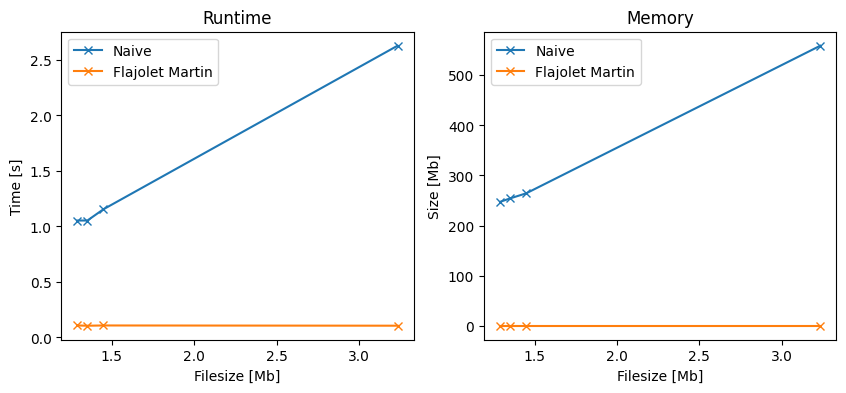

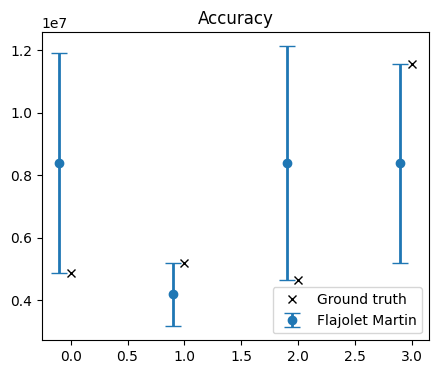

In [2]:
from evaluate.plots import plot_performance, plot_accuracy_FM, plot_accuracies

naive_results, fm_results = [], []
for file in files:
    naive_results.append(track_memory_and_runtime("build/source/naivecounting", file))
    fm_results.append(track_memory_and_runtime("build/source/flajoletmartin", file))

file_sizes = [os.path.getsize(file) for file in files]
results = np.array([naive_results, fm_results])
algorithms = ["Naive", "Flajolet Martin"]

plot_performance(results, algorithms, file_sizes)
plot_accuracy_FM(results, algorithms)

#### Observations:
- Less space consumption: hash $h(x) \rightarrow [0,L]$ requires $\log(L) \approx \log(n)$ space for $n$ distinct elements i.e. exponential less space w.r.t. sequence length $n$
- Large variance! How could you compensate that?

<!-- TODO:
- Test the quality and run time of flajolet_martin() for different (number of) hash functions using cmp_hashs.py --


### HyperLogLog

#### Refinement:
- split $\mathcal{M}$ into $m$ subsets
- estimate cardinalities of subsets
- return mean

The normalized version of the harmonic mean is the estimate

$E:=\frac{\alpha_m m^2}{\sum_{j=1}^m 2^{-M(j)}}.$

for $m$ subsets $M(i)$ and normalization constant $\alpha_m \approx 0.7$.

**TODO** Implement hyperloglog() in hyperloglog.cpp.

Let us compare run time, space consumption, and accuracy to Flajolet-Martin and the exact algorithm:

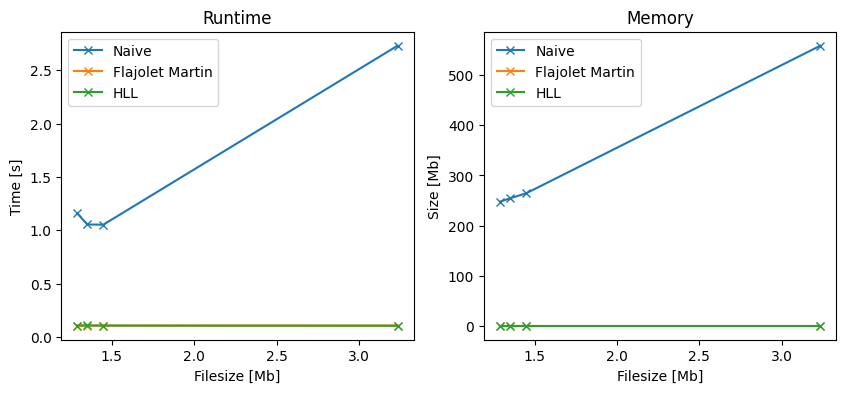

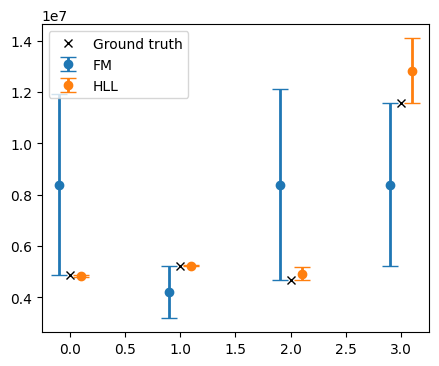

In [3]:
naive_results, fm_results, hll_results = [], [], []
for file in files:
    naive_results.append(track_memory_and_runtime("build/source/naivecounting", file))
    fm_results.append(track_memory_and_runtime("build/source/flajoletmartin", file))
    hll_results.append(track_memory_and_runtime("build/source/hyperloglog", file))

file_sizes = [os.path.getsize(file) for file in files]
results = np.array([naive_results, fm_results, hll_results])
algorithms = ["Naive", "Flajolet Martin", "HLL"]

plot_performance(results, algorithms, file_sizes)
plot_accuracies(results, algorithms)

- Test hyperloglog() for different hash functions using cmp_hashs.py ?

In [ ]:
##



#### Observations:

- Smaller variance
- Less space consumption: $O(\log \log n)$


## Set Similarity

(Dis-)similarity of two sets $A$ and $B$ can be measured with Jaccard similarity
$$
J(A,B) := \frac{|A \cap B|}{|A \cup B|}
$$


### Naive Algorithm

Hashmap or bitvector

TODO implement...

Space linear w.r.t. total number of distinct elements

Comparing $n$ sets requires $O(n^2)$ pairwise comarisons.
Keeping hashmaps of all sets of size $O(m)$ in memory for faster comparison costs $O(n m)$ space.

Impractical for big data.


### MinHashing

Let MinHash $h_{\min}(A) = \min \lbrace h(x) \mid x \in A \rbrace$ and
$$
J_h(A,B) := \begin{cases}1, & \text{if } h_{\min}(A) = h_{\min}(B)\\ 0 & \text{otw.}\end{cases},
$$
Then $E[J_h(A,B)] = J(A,B)$.

Algorithm:

- sample $h_{\min}$ from $k$ random permutations of $h$
- let $l$ be the number of permutated hash functions with $h_{\min}(A) = h_{\min}(B)$
- estimate $J(A,B)$ by $l/k$

A random permutation of $h$ can be e.g.:
$$
h_i(x) = a_i x + b_i \mod p
$$
for prime number $p$ and random $a_i,b_i \in \lbrace 1,\ldots,p\rbrace$.

TODO:
- implement...
- Compare run time and accuracy to exact algorithm. Use todo.py
- Test the accuracy and run time of MinHash for different hash functions and number of permutations

For any $\epsilon > 0$ there is a $k \in O(1/\epsilon^2)$ s.t. the expected error is at most $\epsilon$.

How many hash functions do you need to have an expected error at most $.05$?


### FracMinHashing

Let $h: \Omega \Rightarrow [0,H]$ be a hash function for $H \in \mathbb{N}$ and $s \in [0,1]$ be a scaling factor. FracMinHash
$$
FRAC_{s}(A) := \min \{ h(x) \mid x \in A \land h(x) \leq H s \}.
$$

TODO
- implement...
- Compare (Frac)MinHashing run time and accuracy. Use todo.py




## Take Aways

- Certain tasks for massive data as in molecular biology require data sketching.
- With a bit of randomness, measures for distinct elements in a set become tractable for big data.
- Especially, relying proximity measures that require pairwise comparisons.

